<a href="https://colab.research.google.com/github/Pakopac/Monkey_Species_CNN/blob/master/MonkeySpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monkey Species Recognition CNN

Welcome in this notebook of the project ML recognition monkey species. \
Here we will describe step by step how to build a CNN model to a make a prediction of a specie of monkey from an image. \

## Setup

First we need to import the librairies needed. 

In [26]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import h5py
import pandas as pd
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Data Visualization
from matplotlib import pyplot as plt

In [ ]:
# GPU mode for colab notebook
from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"

I'm importing datas from my drive, I got the datas here: https://www.kaggle.com/slothkong/10-monkey-species

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab_Notebooks/monkey/'

Mounted at /content/drive


Define Arrays with labels, types and some test images

In [ ]:
test_labels = ["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
test_images = [
    "https://projectzerofootprint.com/wp-content/uploads/2016/08/monkey-2-1080x768.jpg",
    "https://i.ytimg.com/vi/Ptisy32iRRA/hqdefault.jpg",
    "https://images.pond5.com/red-uakari-monkey-footage-064800523_iconl.jpeg",
    "https://thejapanalps.com/wp-content/uploads/2020/03/nihonsaru01.jpg",
    "https://www.zoo-leipzig.de/fileadmin/_processed_/e/c/csm_Weissbauch-Zwergseidenaeffchen_3_c46c37b6a1.jpg",
    "https://cdn.britannica.com/05/181805-050-C9682415/capuchin-monkey.jpg",
    "https://www.neprimateconservancy.org/uploads/1/5/3/8/15380094/silvery-marmoset-istock-153473655-resize_45.jpg",
    "https://study.com/cimages/multimages/16/squirrel_monkeys.png",
    "https://ars.els-cdn.com/content/image/3-s2.0-B9780124095274000171-f17-04-9780124095274.jpg",
    "https://media-cdn.tripadvisor.com/media/photo-s/0a/67/93/f5/nilgiri-langur-karunkorangu.jpg"
]
monkey_species_type = ["Mantled Howler","Patas Monkey","Bald Uakari",
                        "Japanese Macaque","Pygmy Marmoset","White Headed Capuchin",
                        "Silvery Marmoset","Ommon Squirrel Monkey",
                        "Black Headed Night Monkey","Nilgiri Langur"]

Define hyperparameters here.

In [ ]:
# Number trained/test images for model
N_train = 200
N_val = 80
# Image size for model
img_width = 150
img_height = 150
# Number of time iterate
epochs = 10
batch_size = 4

Informations per species are listed in monkey_labels.txt with the label, the names, the number of train images and the number of validations images

## EDA / Preprocessing

In [ ]:
# We define columns and display as a pandas dataframe
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
df = pd.read_csv(data_dir + "monkey_labels.txt", names=cols, skiprows=1)
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


We can check the proportion of images of each species as a diagram. \
We have about the same values, in train we have between 130 and 150 images of each and in test we have between 25 and 30 images

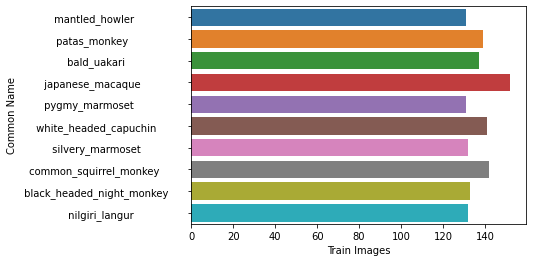

In [ ]:
sns.barplot(x = df["Train Images"], y = df["Common Name"])
plt.show()

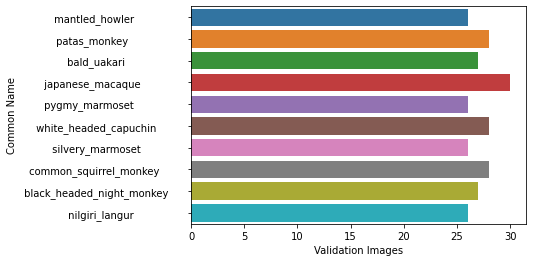

In [ ]:
sns.barplot(x = df["Validation Images"], y = df["Common Name"])
plt.show()

We can load an image with kpi.load_image and convert to an array to test the render of image

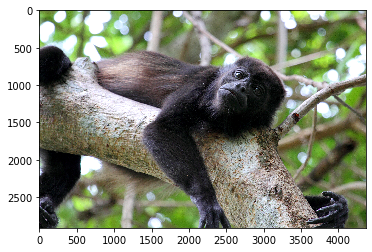

In [ ]:
img = kpi.load_img(data_dir+'training/training/n0/n0021.jpg')
# Convert as array to show with pyplot
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

Display one image of each

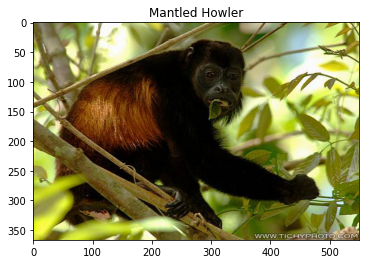

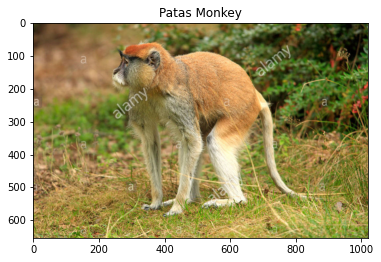

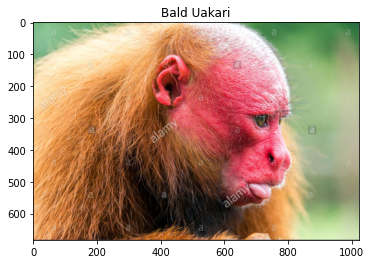

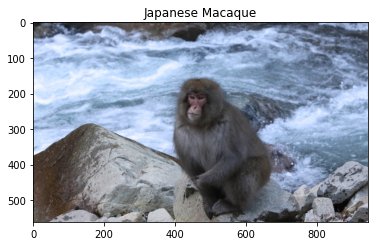

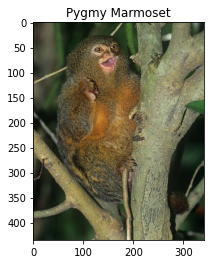

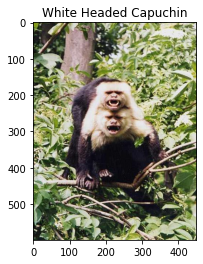

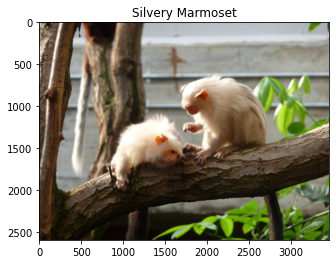

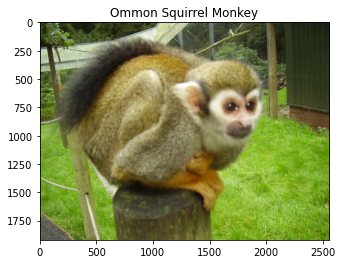

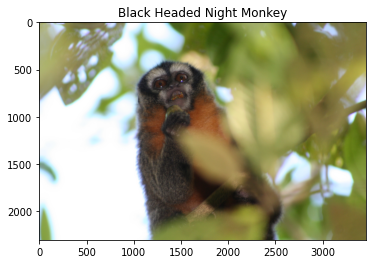

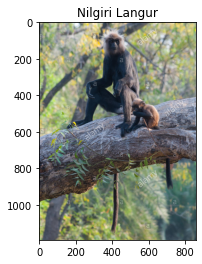

In [ ]:
# Get first image of each directory in training and display with pyplot
for (i,label) in enumerate(test_labels):
  response = data_dir + "training/training/" + label +  "/" + os.listdir(data_dir + "training/training/" + label)[0]
  img = Image.open(response)
  image = tf.keras.utils.img_to_array(img.resize((224, 224)))
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  plt.title(monkey_speciets_type[i])
  plt.imshow(img)
  plt.show()

## Model

Define train and test generator for model

In [ ]:
# data augmentation on train (zoom, rotate, rescale...)
train_datagen = kpi.ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir + 'training/training',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    data_dir + 'validation/validation',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

Found 895 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Define model

In [ ]:
model_base = tf.keras.applications.MobileNet(weights='imagenet',include_top=False)

x = model_base.output
x = kl.GlobalAveragePooling2D()(x)
x = kl.Dense(512,activation='relu')(x)
predictions = kl.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
MobileNet_model = km.Model(inputs= model_base.input, outputs=predictions)

In [ ]:
Xception_base =  tf.keras.applications.Xception(weights='imagenet', include_top=False)

x = Xception_base.output
x = kl.GlobalAveragePooling2D()(x)
x = kl.Dense(512, activation='relu')(x)
predictions = kl.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
Xception_model = km.Model(inputs=Xception_base.input, outputs=predictions)

83697664/83683744 [==============================] - 1s 0us/step


Model fit

In [27]:
# Compile with categorical argument
MobileNet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9) ,metrics=['accuracy'])
history = MobileNet_model.fit_generator(train_generator, epochs=10, shuffle=True, verbose=1, validation_data=validation_generator)

In [ ]:
# Function for plot accuracy/loss
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()
    plt.show()

In [ ]:
# fit history
loses=pd.DataFrame(MobileNet_model.history.history)
loses

,loss,accuracy,val_loss,val_accuracy
0,1.839044,0.356425,1.613707,0.599265
1,1.100295,0.673743,1.244459,0.702206
2,0.853059,0.737430,1.003552,0.727941
3,0.720982,0.776536,0.878037,0.772059
4,0.639314,0.801117,0.851303,0.764706
5,0.525925,0.842458,0.744884,0.790441
6,0.545335,0.826816,0.680078,0.797794
7,0.436669,0.871508,0.616981,0.805147
8,0.442743,0.860335,0.572994,0.819853
9,0.367704,0.894972,0.526669,0.838235


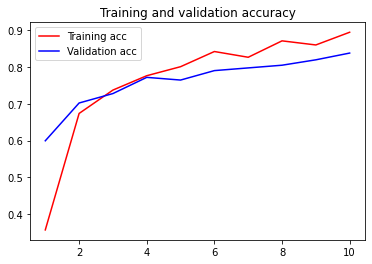

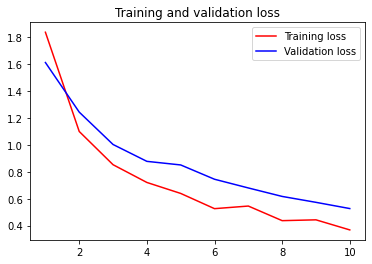

In [ ]:
# 1- history training/validation accuracy over the epochs
# 2- history training/validation loss over the epochs
history_plot(history)

Save model

In [ ]:
MobileNet_model.save(data_dir + "model_mobileNet.h5")

## Predictions

Get predictions with tests images: predict/real 

[[0.02312658 0.04267623 0.24623856 0.06035775 0.13908754 0.06658477
  0.10532091 0.05668633 0.17121725 0.08870403]]


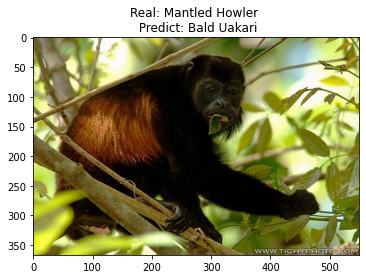

[[0.03618671 0.12152371 0.16758542 0.05590012 0.12765206 0.02987318
  0.15895554 0.05836625 0.20213126 0.04182575]]


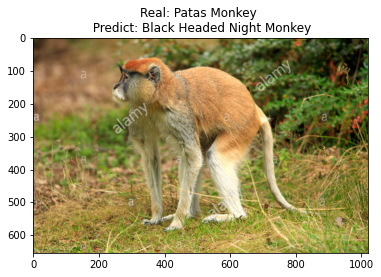

[[0.03513939 0.09323967 0.24714977 0.06987742 0.12100229 0.04171789
  0.14846218 0.05023335 0.15501243 0.03816558]]


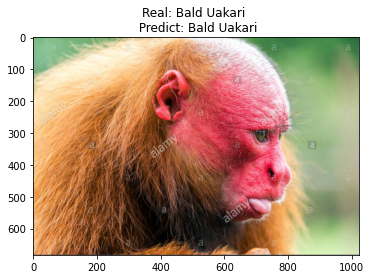

[[0.01919108 0.09753031 0.31660104 0.05773417 0.10991506 0.02426879
  0.09278852 0.05250673 0.16252664 0.06693771]]


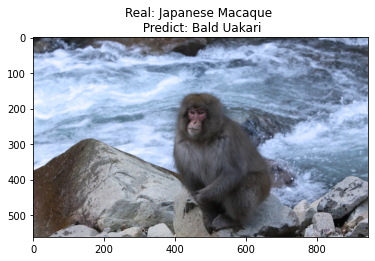

[[0.04810704 0.07788687 0.26669717 0.04851116 0.09811138 0.03257031
  0.07467674 0.05830768 0.23110248 0.06402926]]


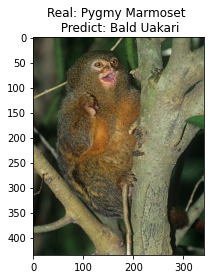

[[0.02516657 0.17262809 0.13402982 0.0614777  0.11301863 0.05630136
  0.1100012  0.06672044 0.16404611 0.09661005]]


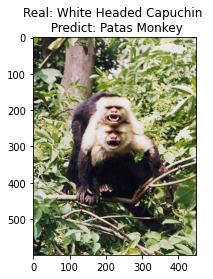

[[0.03417886 0.10981767 0.28163016 0.06033392 0.09616903 0.02897496
  0.10245763 0.04451367 0.18444087 0.05748316]]


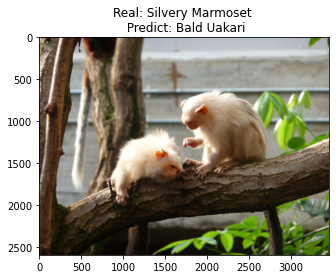

[[0.02981912 0.08774708 0.41194123 0.02706912 0.07129964 0.02345569
  0.09759881 0.07405995 0.14405285 0.03295644]]


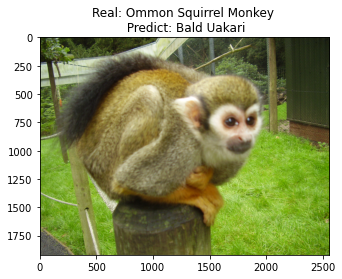

[[0.06736789 0.07645751 0.32636282 0.04422071 0.09757383 0.03719019
  0.15047672 0.07357854 0.08211832 0.04465343]]


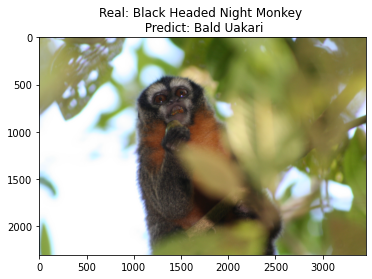

[[0.03512531 0.11940336 0.21188077 0.04457711 0.12505591 0.06237423
  0.11225797 0.07315248 0.15189408 0.06427884]]


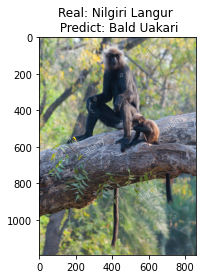

In [30]:
import io
import requests
from PIL import Image
import keras

model = keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/monkey/model_mobileNet.h5")
for (i,label) in enumerate(test_labels):
    response = data_dir + "training/training/" + label +  "/" + os.listdir(data_dir + "training/training/" + label)[0]
    img = Image.open(response)
    image = tf.keras.utils.img_to_array(img.resize((224, 224)))
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    prediction=model.predict(image)
    print(prediction)
    output = np.argmax(prediction)
        
    plt.title("Real: {} \n Predict: {}".format(monkey_species_type[i], monkey_species_type[output]))
    plt.imshow(img)
    plt.show()